> **前言：** 学习了 Sutton 的《强化学习（第二版）》中时序差分学习的“预测”部分内容。前两章中，书介绍了 **动态规划** 与 **蒙特卡洛方法** ，我们从二者与 时序差分学习 的对比开始讲起。

笔者阅读的是中文书籍，所提到的公式，笔者将给出其在英文书籍上的页码。英文书籍见 Sutton 个人主页：
[http://incompleteideas.net/book/the-book.html](http://incompleteideas.net/book/the-book.html)

本次笔记内容：
- 6.1 时序差分预测
- 6.2 时序差分预测的优势
- 6.3 TD(0) 的最优性

### DP、MC、TD对比

| 中文名       | 英文名                       | 简称 |
|--------------|------------------------------|------|
| 动态规划     | Dynamic Programming          | DP   |
| 蒙特卡洛方法 | Monte Carlo Method           | MC   |
| 时序差分学习 | Temporal-Difference Learning | TD   |

笔者将根据书中内容，对三者特性进行总结：

| 特性                                                    | DP  | MC  | TD  |
|---------------------------------------------------------|-----|-----|-----|
| 是否需要完备的环境模型（需要知道 $p(s',r \vert (s,a))$ ）| Yes | No  | No  |
| 期望更新（计算基于采样的所有可能后继节点的完整分布）    | Yes | No  | No  |
| 采样更新（计算基于采样得到的单个后继节点的样本数据）    | No  | Yes | Yes |
| 无需等待交互的最终结果                                  | Yes | No  | Yes |
| 根据幕来更新（MC到幕尾知道$G_t$，才能开始对$V(s)$更新） | No  | Yes | No  |
|基于已存在的$V$对$V_\pi$估计|Yes|No|Yes

### TD(0)

TD(0) 的价值更新公式为：

$$V(s) \leftarrow V(S) + \alpha [R + \gamma V(S') - V(S)]$$

其中，中括号内为 TD 误差：

$$\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$$

注意，如果价值函数数组在这一幕中没有改变（蒙特卡洛方法中就是），**那么蒙特卡洛误差可以写为 TD 误差之和**：

$$\begin{aligned}
G_{t}-V\left(S_{t}\right) &=R_{t+1}+\gamma G_{t+1}-V\left(S_{t}\right)+\gamma V\left(S_{t+1}\right)-\gamma V\left(S_{t+1}\right) \\
&=\delta_{t}+\gamma\left(G_{t+1}-V\left(S_{t+1}\right)\right) \\
&=\delta_{t}+\gamma \delta_{t+1}+\gamma^{2}\left(G_{t+2}-V\left(S_{t+2}\right)\right) \\
&=\delta_{t}+\gamma \delta_{t+1}+\gamma^{2} \delta_{t+2}+\cdots+\gamma^{T-t-1} \delta_{T-1}+\gamma^{T-t}\left(G_{T}-V\left(S_{T}\right)\right) \\
&=\delta_{t}+\gamma \delta_{t+1}+\gamma^{2} \delta_{t+2}+\cdots+\gamma^{T-t-1} \delta_{T-1}+\gamma^{T-t}(0-0) \\
&=\sum_{k=t}^{T-1} \gamma^{k-t} \delta_{k}
\end{aligned}$$

如果V在该幕中变化了，那么该公式就不准确。但是，如果时刻步长较小，那么该等式仍能近似成立。

### 时序差分预测方法的优势

首先。 TD 方法在数学上可以保证收敛到正确的值。

有随机游走的例子，可见 Sutton 书第125页：

![](images/05-01.png)

代码可见：
[github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/random_walk.py](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter06/random_walk.py)

在这个例子中， TD 总是比 MC 收敛得快。

### 批量更新与TD(0)的最优性

批量更新可以用下列代码说明，可以看注释来理解。

```python
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm

# 0 is the left terminal state
# 6 is the right terminal state
# 1 ... 5 represents A ... E
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
# For convenience, we assume all rewards are 0
# and the left terminal state has value 0, the right terminal state has value 1
# This trick has been used in Gambler's Problem
VALUES[6] = 1

# set up true state values
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1

ACTION_LEFT = 0
ACTION_RIGHT = 1

# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def temporal_difference(values, alpha=0.1, batch=False):
    '''
    在 python 中， values 不是局部变量
    这里为传址调用，这就是为什么不用 return values
    '''
    state = 3
    trajectory = [state]
    rewards = [0]
    while True:
        old_state = state
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        # Assume all rewards are 0
        reward = 0
        trajectory.append(state)
        # TD update
        if not batch:
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        if state == 6 or state == 0:
            break
        rewards.append(reward)
    return trajectory, rewards

# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def monte_carlo(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [3]

    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    '''
    MC 产生随机序列，并且未必更新 values
    batch = False 才 update values
    batch = True 时表示“批量训练”：
    即产生一幕序列，然后疯狂由这幕序列反复更新 V(S)
    直到 V(S) 更新不动了（前后两次差值小于一定值）
    再生成新一幕序列，继续反复更新 V(S)
    '''
    while True:
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break

    if not batch:
        for state_ in trajectory[:-1]:
            # MC update
            values[state_] += alpha * (returns - values[state_])

    '''
    没有折扣，因此所有动作对应的 G_t 都为 G_T (1 or 0)
    即 [returns] * (len(trajectory) - 1)
    '''
    return trajectory, [returns] * (len(trajectory) - 1)

# Figure 6.2
# @method: 'TD' or 'MC'
def batch_updating(method, episodes, alpha=0.001):
    # perform 100 independent runs
    runs = 100
    total_errors = np.zeros(episodes)
    for r in tqdm(range(0, runs)):
        current_values = np.copy(VALUES)
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []
        for ep in range(episodes):
            if method == 'TD':
                trajectory_, rewards_ = temporal_difference(current_values, batch=True)
            else:
                trajectory_, rewards_ = monte_carlo(current_values, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)
            while True:
                # keep feeding our algorithm with trajectories seen so far until state value function converges
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    '''
                    原来 批量TP 与 批量MC 的差别只在于两点：
                    - 产生序列的方式：
                    - - 在这个例子中，在 TD 看来，每步的收益与本身的动作有关，即前面动作收益皆为 0 ，与最后一次触发终止的动作无关 0 或 1
                    - - 在 MC 看来，（因为没有折扣），每步的收益与最后一次触发终止的动作有关 0 或 1
                    - 更新公式，如下
                    '''
                    for i in range(0, len(trajectory_) - 1):
                        if method == 'TD':
                            updates[trajectory_[i]] += rewards_[i] + current_values[trajectory_[i + 1]] - current_values[trajectory_[i]]
                        else:
                            updates[trajectory_[i]] += rewards_[i] - current_values[trajectory_[i]]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                current_values += updates
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))
        total_errors += np.asarray(errors)
    total_errors /= runs
    return total_errors

def figure_6_2():
    episodes = 100 + 1
    td_erros = batch_updating('TD', episodes)
    mc_erros = batch_updating('MC', episodes)

    plt.plot(td_erros, label='TD')
    plt.plot(mc_erros, label='MC')
    plt.xlabel('episodes')
    plt.ylabel('RMS error')
    plt.legend()

    plt.savefig('images/figure_6_2.png')
    plt.close()
```

原来 批量TP 与 批量MC 的差别只在于两点：
- 产生序列的方式：
- - 在这个例子中，在 TD 看来，每步的收益与本身的动作有关，即前面动作收益皆为 0 ，与最后一次触发终止的动作无关 0 或 1
- - 在 MC 看来，（因为没有折扣），每步的收益与最后一次触发终止的动作有关 0 或 1
- 更新公式

输出为：

![](images/05-02.png)

可见，在这个例子中 TD 比 MC 更好一些。

批量 MC 总是找出最小化训练集上均方误差的估计；而批量 TD(0) 总是找出完全符合马尔科夫过程模型的最大似然估计参数。批量 T(0) 通常收敛到的就是确定性等价估计。

TD 方法可以使用不超过 |状态数| 的内存，比直接使用最大似然估计性能优良。

****

知道了如何使用 TD 预测价值，接下来，我们将考虑如何在试探和开发之间做出权衡，即下次笔记讨论：
- 同轨策略（Sarsa）；
- 离轨策略（Q-learning）。


### Example 6.2 Random Walk

见上述截图。

In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

# 0 is the left terminal state
# 6 is the right terminal state
# 1 ... 5 represents A ... E
VALUES = np.zeros(7)
VALUES[1:6] = 0.5
# For convenience, we assume all rewards are 0
# and the left terminal state has value 0, the right terminal state has value 1
# This trick has been used in Gambler's Problem
VALUES[6] = 1

# set up true state values
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1

ACTION_LEFT = 0
ACTION_RIGHT = 1

# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def temporal_difference(values, alpha=0.1, batch=False):
    '''
    在 python 中， values 不是局部变量
    这里为传址调用，这就是为什么不用 return values
    '''
    state = 3
    trajectory = [state]
    rewards = [0]
    while True:
        old_state = state
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        # Assume all rewards are 0
        reward = 0
        trajectory.append(state)
        # TD update
        if not batch:
            values[old_state] += alpha * (reward + values[state] - values[old_state])
        if state == 6 or state == 0:
            break
        rewards.append(reward)
    return trajectory, rewards

# @values: current states value, will be updated if @batch is False
# @alpha: step size
# @batch: whether to update @values
def monte_carlo(values, alpha=0.1, batch=False):
    state = 3
    trajectory = [3]

    # if end up with left terminal state, all returns are 0
    # if end up with right terminal state, all returns are 1
    '''
    MC 产生随机序列，并且未必更新 values
    batch = False 才 update values
    batch = True 时表示“批量训练”：
    即产生一幕序列，然后疯狂由这幕序列反复更新 V(S)
    直到 V(S) 更新不动了（前后两次差值小于一定值）
    再生成新一幕序列，继续反复更新 V(S)
    '''
    while True:
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        trajectory.append(state)
        if state == 6:
            returns = 1.0
            break
        elif state == 0:
            returns = 0.0
            break

    if not batch:
        for state_ in trajectory[:-1]:
            # MC update
            values[state_] += alpha * (returns - values[state_])

    '''
    没有折扣，因此所有动作对应的 G_t 都为 G_T (1 or 0)
    即 [returns] * (len(trajectory) - 1)
    '''
    return trajectory, [returns] * (len(trajectory) - 1)

# Example 6.2 left
def compute_state_value():
    episodes = [0, 1, 10, 100]
    current_values = np.copy(VALUES)
    plt.figure(1)
    for i in range(episodes[-1] + 1):
        if i in episodes:
            '''
            这个写的及其巧妙
            for i in range(episodes[-1] + 1)
            保证了：从 0 幕 学习到 100 幕；
            if i in episodes
            保证了：只在 0, 1, 10, 100 时才画图看效果
            '''
            plt.plot(current_values, label=str(i) + ' episodes')
        temporal_difference(current_values)
    plt.plot(TRUE_VALUE, label='true values')
    plt.xlabel('state')
    plt.ylabel('estimated value')
    plt.legend()

# Example 6.2 right
def rms_error():
    # Same alpha value can appear in both arrays
    td_alphas = [0.15, 0.1, 0.05]
    mc_alphas = [0.01, 0.02, 0.03, 0.04]
    episodes = 100 + 1
    runs = 100
    for i, alpha in enumerate(td_alphas + mc_alphas):
        total_errors = np.zeros(episodes)
        if i < len(td_alphas):
            method = 'TD'
            linestyle = 'solid'
        else:
            method = 'MC'
            linestyle = 'dashdot'
        for r in tqdm(range(runs)):
            errors = []
            '''
            这里的 current_values 进行初始化
            赋给其常量值（初始值） VALUES
            '''
            current_values = np.copy(VALUES)
            for i in range(0, episodes):
                errors.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))
                if method == 'TD':
                    temporal_difference(current_values, alpha=alpha)
                else:
                    monte_carlo(current_values, alpha=alpha)
            total_errors += np.asarray(errors)
        total_errors /= runs
        plt.plot(total_errors, linestyle=linestyle, label=method + ', alpha = %.02f' % (alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()

# Figure 6.2
# @method: 'TD' or 'MC'
def batch_updating(method, episodes, alpha=0.001):
    # perform 100 independent runs
    runs = 100
    total_errors = np.zeros(episodes)
    for r in tqdm(range(0, runs)):
        current_values = np.copy(VALUES)
        errors = []
        # track shown trajectories and reward/return sequences
        trajectories = []
        rewards = []
        for ep in range(episodes):
            if method == 'TD':
                trajectory_, rewards_ = temporal_difference(current_values, batch=True)
            else:
                trajectory_, rewards_ = monte_carlo(current_values, batch=True)
            trajectories.append(trajectory_)
            rewards.append(rewards_)
            while True:
                # keep feeding our algorithm with trajectories seen so far until state value function converges
                updates = np.zeros(7)
                for trajectory_, rewards_ in zip(trajectories, rewards):
                    '''
                    原来 批量TP 与 批量MC 的差别只在于两点：
                    - 产生序列的方式：
                    - - 在这个例子中，在 TD 看来，每步的收益与本身的动作有关，即前面动作收益皆为 0 ，与最后一次触发终止的动作无关 0 或 1
                    - - 在 MC 看来，（因为没有折扣），每步的收益与最后一次触发终止的动作有关 0 或 1
                    - 更新公式，如下
                    '''
                    for i in range(0, len(trajectory_) - 1):
                        if method == 'TD':
                            updates[trajectory_[i]] += rewards_[i] + current_values[trajectory_[i + 1]] - current_values[trajectory_[i]]
                        else:
                            updates[trajectory_[i]] += rewards_[i] - current_values[trajectory_[i]]
                updates *= alpha
                if np.sum(np.abs(updates)) < 1e-3:
                    break
                # perform batch updating
                current_values += updates
            # calculate rms error
            errors.append(np.sqrt(np.sum(np.power(current_values - TRUE_VALUE, 2)) / 5.0))
        total_errors += np.asarray(errors)
    total_errors /= runs
    return total_errors

def example_6_2():
    plt.figure(figsize=(10, 20))
    plt.subplot(2, 1, 1)
    compute_state_value()

    plt.subplot(2, 1, 2)
    rms_error()
    plt.tight_layout()

    plt.show()

def figure_6_2():
    episodes = 100 + 1
    td_erros = batch_updating('TD', episodes)
    mc_erros = batch_updating('MC', episodes)

    plt.plot(td_erros, label='TD')
    plt.plot(mc_erros, label='MC')
    plt.xlabel('episodes')
    plt.ylabel('RMS error')
    plt.legend()

    plt.show()


100%|█████████████████████████████████████| 100/100 [00:00<00:00, 320.62it/s]


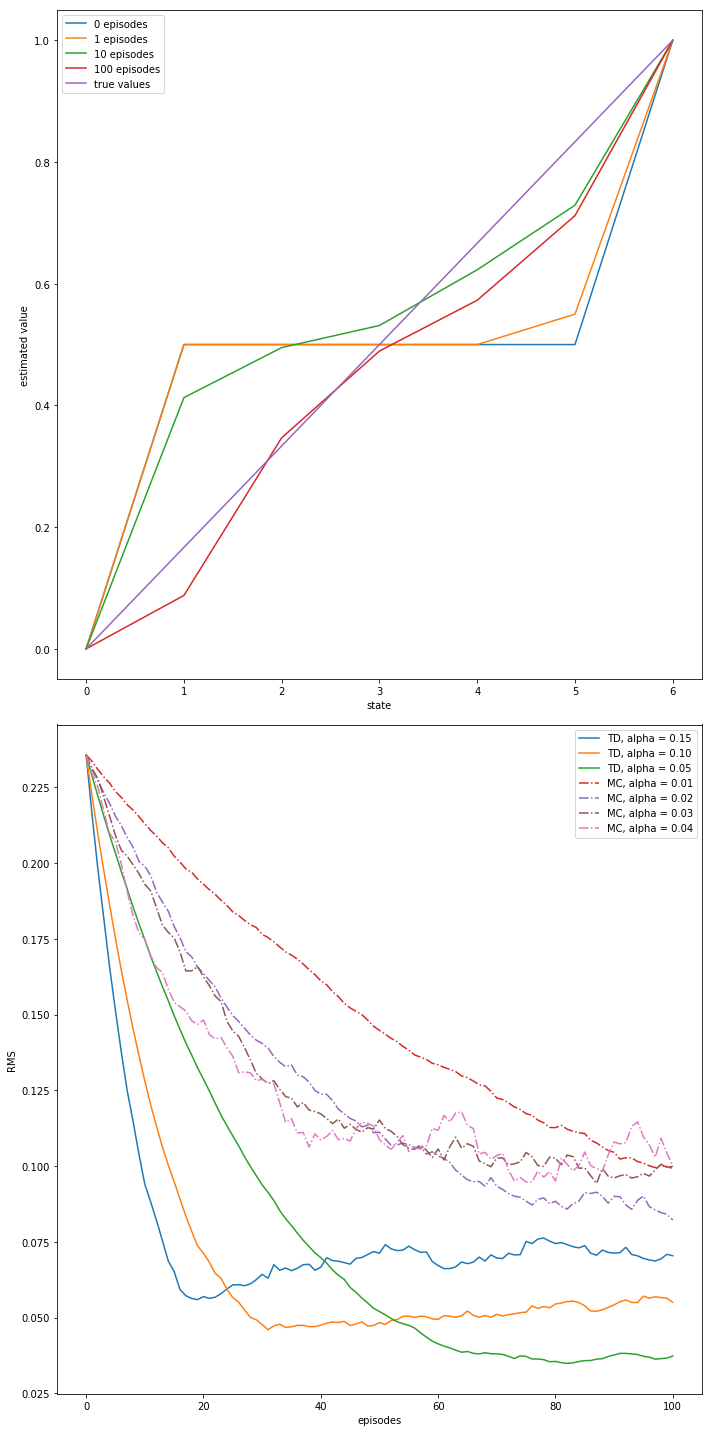

In [2]:
example_6_2()

100%|██████████████████████████████████████| 100/100 [00:37<00:00,  2.57it/s]


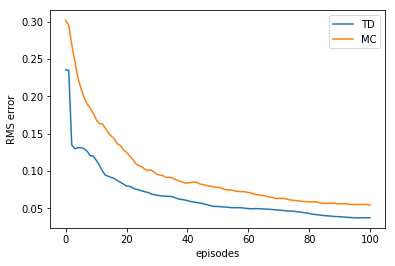

In [3]:
figure_6_2()